# Taller de modelación con GeoClaw
### Análisis y Diseño Hidráulico
### Semestre 1, 2015
### José Galaz

#Introducción

El objetivo de este taller es trabajar sobre un ejemplo sencillo que permitirá tener un ejemplo de aplicación del software *GeoClaw*, completamente funcional en la máquina virtual, y que servirá como punto de partida para modelar problemas más complejos.

GeoClaw es parte de ClawPack (v5.3 en este caso), un software gratuito de código abierto desarrollado en la Universidad de Washington, y está enfocado en leyes de conservación relacionadas a problemas de Geofísica. En nuestro caso, permite resolver las ecuaciones de aguas someras (St. Venant 2D) considerando **variaciones fuertes en la topografía**, **fricción con el fondo**, y manejando naturalmente **ondas de choque** (discontinuidades) mediante la solución al problema de Riemann entre cada celda. Además, para mejorar el rendimiento de la simulación, dispone de **mallas adaptativas**, que permiten variar la discretización espacial a lo largo del tiempo de la simulación. La (excelente) documentación, aspectos sobre la licencia del código, o sobre si se interesan en ser desarrolladores del programa y otros temas, pueden encontrar en el [sitio web oficial](https://www.clawpack.org).

En general el proceso de la simulación (y de este cuaderno) se podrá dividir en las siguientes etapas

1. Crear archivos con la información de la topografía y la condicion inicial de $h,u,v$
2. Fijar los parámetros de la simulación en el setrun.py
3. Correr la simulación
4. Procesar los resultados

Antes de empezar, importamos los paquetes necesarios para trabajar

In [1]:
from clawpack.geoclaw import topotools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#0. Error: "Too many dt reductions"

Para que no aparezca el error 
    **** Too many dt reductions ****

abran con un editor de texto el archivo 

    /home/clawuser/clawpack/geoclaw/src/2d/shallow/tick.f
    
y busquen con CTRL+F la línea que dice

    if (ntogo(level) .gt. 100) then
    
y cambien el 100 por un número más grande, por ejemplo   10000, para que quede

    if (ntogo(level) .gt. 10000) then    

por seguridad ejecuten después la siguiente celda

In [2]:
!make new

makefile:187: warning: overriding commands for target `all'
/home/jgm/Downloads/clawpack-5.3.0/clawutil/src/Makefile.common:259: warning: ignoring old commands for target `all'
rm -f      /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/qinit.o /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/setprob.o /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/topo_update.o /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/cellgridintegrate2.o /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/topointegral.o /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/bilinearintegral.o /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/stepgrid.o /home/jgm/Downloads/clawpack-5.3.0/riemann/src/rpn2_geoclaw.o /home/jgm/Downloads/clawpack-5.3.0/riemann/src/rpt2_geoclaw.o /home/jgm/Downloads/clawpack-5.3.0/riemann/src/geoclaw_riemann_utils.o /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/src2.o /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2

#1. Crear topografía y condición inicial

Queremos reproducir el (clásico) problema del rompimiento de presa parcial en 2 dimensiones. Para esto, antes que todo, necesitamos definir la condición inicial de las variables conservadas y la topografía del dominio. 

GeoClaw permite ingresar la topografía en archivos ASCII (letras "comunes y corrientes") pero los datos deben estar ordenados de acuerdo a un cierto formato. Nosotros ocuparemos funciones predefinidas de GeoClaw, que permiten crear estos datos a partir de funciones de python. Estas funciones son

    topotools.topo2writer: para escribir en formato tipo 2
    
    topotools.topo1writer: para escribir en formato tipo 1
    
Pueden ver la documentación de ellas ejecutando lineas como a continuación   (funciona con cualquier módulo o función de python, si es que tiene la documentación disponible). 

In [3]:
topotools.topo2writer?

Para la topografía se puede utilizar cualquier formato, pero para la condición inicial, necesitamos obligatoriamente fijar en formato tipo 1. Además, la condición inicial se define como perturbaciones sobre un estado de reposo, en este caso la perturbación viene siendo cuánto nivel de superficie libre sumamos por encima del "nivel 0 del mar". El nivel 0 del mar lo definiremos cuando editemos el archivo setrun.py.

Lo que pasa en la siguiente celda es :
1. Define topofunction y qinitfunction: las funciones que reciben arreglos bidimensionales $x$ e $y$ y retornan un arreglo del mismo tamaño con los valores $z$, para la topografía/sup.libre respectivamente.
2. Define maketopo y makeqinit, funciones que definen parámetros del dominio (extensión) y discretización (número de puntos) y generan archivos en formato geoclaw con las funciones de antes, para esos parámetros.
3. Ejecuta maketopo() y makeqinit()

Les recomiendo que revisen la función 

    np.where

In [4]:
np.where?

In [5]:
#1.
def topofunction(x,y):
    """
    The topography: flat floor everywhere
    except for the reservoir walls
    """
    z = np.zeros(x.shape)
    z = np.where( (np.abs(x-2.)<2.5)*(y<-70.), 15., z)
    z = np.where( (np.abs(x-2.)<2.5)*(y>5.), 15.,z)
    return z

def qinitfunction(x,y):
    """
    Dry above the walls. 10 m height in the left side
    5m in the right side.
    """
    z = np.zeros(x.shape)
    z = np.where( (np.abs(x-2.)<2.5)*(y<-70.), 15., z)
    z = np.where( (np.abs(x-2.)<2.5)*(y>5.), 15.,z)
    h = np.zeros_like(z)
    h = np.where( x<=-0,10.,5.)
    h = np.where( z>0.,0.,h)
    return h
#2.
def maketopo():
    """
    topo2 format for topography
    """    
    xupper = 100.
    yupper = 100.
    xlower = -100.
    ylower = -100.
    nxpoints= 100
    nypoints= 100
    outfile= "channel.topotype2"
    topotools.topo2writer(outfile,topofunction,xlower,xupper,ylower,yupper,nxpoints,nypoints)
def makeqinit():
    """
    topo1 format for qinit
    """    
    xupper = 100.
    yupper = 100.
    xlower = -100.
    ylower = -100.
    nxpoints= 100
    nypoints= 100
    outfile= "qinit.topotype1"
    topotools.topo1writer(outfile,qinitfunction,xlower,xupper,ylower,yupper,nxpoints,nypoints)

#3.
maketopo()
makeqinit()

/home/jgm/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/jgm/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


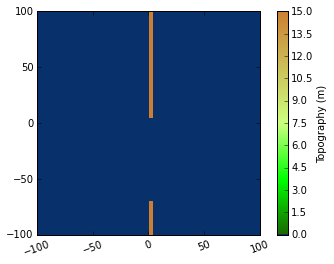

In [6]:
topo = topotools.Topography()
topo.read('channel.topotype2',topo_type=2)
topo.plot()

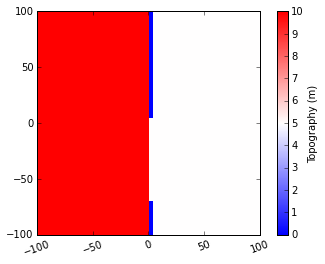

In [7]:
qinit = topotools.Topography()
qinit.read('qinit.topotype1',topo_type=1)
qinit.plot(cmap=topotools.util.clawpack.visclaw.colormaps.blue_white_red)

#2. Editando los parámetros de la simulación: el archivo setrun.py

Para correr la simulación necesitamos obligatoriamente de un buen *Makefile*, un *setrun.py* y opcionalmente un *setplot.py*. Normalmente, a menos que sepas muy bien lo que haces, NO edites el *Makefile* pero no te olvides de colocarlo en el mismo directorio que este cuaderno. El *setrun.py* por otro lado es el que defSinirá todos los parámetros de la simulación, incluidos los archivos (que ya creamos) con la topografía y la condición inicial.

El archivo setrun.py es muy largo y evidencia la complejidad que tiene este tipo de simulación. Pero como siempre, pueden ver que en realidad consta de pequeñas secciones. Las que a nosotros nos interesará editar son:

Sobre el **refinamiento adaptativo**, GeoClaw trabaja con  que tienen resoluciónes que son múltiplos enteros entre ellos. Por esto debemos definir 
1. Una lista con razones de refinamiento (números enteros), por ejemplo en la dirección $x$, r_x = [r_1, r_2,... r_l], y entonces se tendrá que $\Delta x_{1}/\Delta x_{2} = r_1, \Delta x_{2}/\Delta x_{3} = r_2$, etc.
2. (Opcional) Una lista que permita delimitar regiones con niveles de refinamiento mínimo y máximo deseados, para un intervalo de tiempo de la simulación.

En general GeoClaw refinará hasta el máximo nivel posible en cada región. Si una zona no tiene una región de refinamiento definida entonces GeoClaw asume que puede refinar hasta el último nivel. Si por ejemplo definen una región que cubra todo el dominio, y que fije nivelminimo=nivelmaximo=1, entonces por defecto en todo el dominio habrá resolución fija. En general además, las zonas se traslapan bien y una región que aparece más abajo en la lista  reemplaza (si hay traslapo) a las anteriores en esa región.


La mayor parte de los parámetros aparecen también explicados [aquí](http://www.clawpack.org/setrun.html)

    # ---------------
    # Spatial domain:
    # ---------------
    
    - Extensión del dominio: 
        clawdata.lower = [xl,yl] = coordenadas esquina inferior izquierda
        clawdata.upper = [xl,yl] = coordenadas esquina inferior izquierda
    - Resolución de la discretización
        clawdata.num_cells[0] = nx = número de celdas en la dirección x
        clawdata.num_cells[1] = ny = número de celdas en la dirección y
    
    # -------------
    # Output times:
    #--------------
    
    - Cada cuánto tiempo guardará el output en la carpeta _output.
    
    # --------------
    # Time stepping:
    # --------------
    
    - Sobre el número de Courant y los pasos de tiempo
    
  
    # --------------------
    # Boundary conditions:
    # --------------------
    
    - Condiciones de borde: 3  = borde abierto, 1 = borde cerrado (reflectivo)
    
    # ---------------
    # AMR parameters:
    # ---------------   
    
    - Cuántos niveles de refinamiento se usarán
    - Lista de razones de resolución "r_l = dx_{l}/dx_{l-1}"
    - Definición de la extensión de las regiones de refinamiento
    
    # == setgauges.data values ==
     - En esta parte de la sección ARM parameters, se puede epecificar una lista de coordenadas
     en los cuales se quiere guardar la evolución temporal. Sirve para comparar más tarde con mediciones o para graficar un hidrograma

    
y además, la que es exclusiva de GeoClaw

    #-------------------
    def setgeo(rundata):
    #-------------------
    - Parámetros físicos (manning, nivel de reposo del mar, g)
    - Criterio para refinamiento 
        wave_tolerance: si z+h > wave_tolerance + nivel0 entonces refina,
        con nivel0 el nivel de reposo del mar.
    - Archivos de topografía y condición inicial
        *fijar qinit_type=4 para 'perturbar' la superficie libre en reposo (dada por el nivel0),
            con la información en el(los) archivo(s) de condición inicial.
       
    

Con la celda comentada de abajo cargo el setrun.py en la celda subsiguiente, que es el que usé de base para correr esta simuación. Está comentado porque sólo es necesario hacerlo una vez.

Con *%%writefile setrun.py* me aseguro que todo lo que haya en esa celda sobreescriba el contenido del archivo *setrun.py*.

In [8]:
#%load setrun.py

In [9]:
%%writefile setrun.py
# %load setrun.py

"""
Module to set up run time parameters for Clawpack.

The values set in the function setrun are then written out to data files
that will be read in by the Fortran code.

"""

import os
import numpy as np


#------------------------------
def setrun(claw_pkg='geoclaw'):
#------------------------------

    """
    Define the parameters used for running Clawpack.

    INPUT:
        claw_pkg expected to be "geoclaw" for this setrun.

    OUTPUT:
        rundata - object of class ClawRunData

    """

    from clawpack.clawutil import data

    assert claw_pkg.lower() == 'geoclaw',  "Expected claw_pkg = 'geoclaw'"

    num_dim = 2
    rundata = data.ClawRunData(claw_pkg, num_dim)

    #------------------------------------------------------------------
    # GeoClaw specific parameters:
    #------------------------------------------------------------------
    rundata = setgeo(rundata)

    #------------------------------------------------------------------
    # Standard Clawpack parameters to be written to claw.data:
    #   (or to amr2ez.data for AMR)
    #------------------------------------------------------------------
    clawdata = rundata.clawdata  # initialized when rundata instantiated


    # Set single grid parameters first.
    # See below for AMR parameters.


    # ---------------
    # Spatial domain:
    # ---------------

    # Number of space dimensions:
    clawdata.num_dim = num_dim

    # Lower and upper edge of computational domain:
    clawdata.lower[0] = -100.0
    clawdata.upper[0] = 100.0

    clawdata.lower[1] = -100.0
    clawdata.upper[1] = 100.0



    # Number of grid cells: Coarsest grid
    clawdata.num_cells[0] = 20
    clawdata.num_cells[1] = 20


    # ---------------
    # Size of system:
    # ---------------

    # Number of equations in the system:
    clawdata.num_eqn = 3

    # Number of auxiliary variables in the aux array (initialized in setaux)
    clawdata.num_aux = 1

    # Index of aux array corresponding to capacity function, if there is one:
    clawdata.capa_index = 0

    
    
    # -------------
    # Initial time:
    # -------------

    clawdata.t0 = 0.0


    # Restart from checkpoint file of a previous run?
    # Note: If restarting, you must also change the Makefile to set:
    #    RESTART = True
    # If restarting, t0 above should be from original run, and the
    # restart_file 'fort.chkNNNNN' specified below should be in 
    # the OUTDIR indicated in Makefile.

    clawdata.restart = False               # True to restart from prior results
    clawdata.restart_file = 'fort.chk00006'  # File to use for restart data

    # -------------
    # Output times:
    #--------------

    # Specify at what times the results should be written to fort.q files.
    # Note that the time integration stops after the final output time.
    # The solution at initial time t0 is always written in addition.

    clawdata.output_style = 1

    if clawdata.output_style == 1:
        # Output nout frames at equally spaced times up to tfinal:
        clawdata.num_output_times = 30
        clawdata.tfinal = 30.
        clawdata.output_t0 = True  # output at initial (or restart) time?

    elif clawdata.output_style == 2:
        # Specify a list of output times.
        clawdata.output_times = [0.5, 1.0]

    elif clawdata.output_style == 3:
        # Output every iout timesteps with a total of ntot time steps:
        clawdata.output_step_interval = 1
        clawdata.total_steps = 1
        clawdata.output_t0 = True
        

    clawdata.output_format = 'ascii'      # 'ascii' or 'netcdf' 

    clawdata.output_q_components = 'all'   # could be list such as [True,True]
    clawdata.output_aux_components = 'none'  # could be list
    clawdata.output_aux_onlyonce = True    # output aux arrays only at t0



    # ---------------------------------------------------
    # Verbosity of messages to screen during integration:
    # ---------------------------------------------------

    # The current t, dt, and cfl will be printed every time step
    # at AMR levels <= verbosity.  Set verbosity = 0 for no printing.
    #   (E.g. verbosity == 2 means print only on levels 1 and 2.)
    clawdata.verbosity = 0



    # --------------
    # Time stepping:
    # --------------

    # if dt_variable==1: variable time steps used based on cfl_desired,
    # if dt_variable==0: fixed time steps dt = dt_initial will always be used.
    clawdata.dt_variable = True

    # Initial time step for variable dt.
    # If dt_variable==0 then dt=dt_initial for all steps:
    clawdata.dt_initial = 0.0001

    # Max time step to be allowed if variable dt used:
    clawdata.dt_max = 1e+99

    # Desired Courant number if variable dt used, and max to allow without
    # retaking step with a smaller dt:
    clawdata.cfl_desired = 0.75
    clawdata.cfl_max = 0.85

    # Maximum number of time steps to allow between output times:
    clawdata.steps_max = 5000




    # ------------------
    # Method to be used:
    # ------------------

    # Order of accuracy:  1 => Godunov,  2 => Lax-Wendroff plus limiters
    clawdata.order = 2
    
    # Use dimensional splitting? (not yet available for AMR)
    clawdata.dimensional_split = 'unsplit'
    
    # For unsplit method, transverse_waves can be 
    #  0 or 'none'      ==> donor cell (only normal solver used)
    #  1 or 'increment' ==> corner transport of waves
    #  2 or 'all'       ==> corner transport of 2nd order corrections too
    clawdata.transverse_waves = 2

    # Number of waves in the Riemann solution:
    clawdata.num_waves = 3
    
    # List of limiters to use for each wave family:  
    # Required:  len(limiter) == num_waves
    # Some options:
    #   0 or 'none'     ==> no limiter (Lax-Wendroff)
    #   1 or 'minmod'   ==> minmod
    #   2 or 'superbee' ==> superbee
    #   3 or 'mc'       ==> MC limiter
    #   4 or 'vanleer'  ==> van Leer
    clawdata.limiter = ['mc', 'mc', 'mc']

    clawdata.use_fwaves = True    # True ==> use f-wave version of algorithms
    
    # Source terms splitting:
    #   src_split == 0 or 'none'    ==> no source term (src routine never called)
    #   src_split == 1 or 'godunov' ==> Godunov (1st order) splitting used, 
    #   src_split == 2 or 'strang'  ==> Strang (2nd order) splitting used,  not recommended.
    clawdata.source_split = 'godunov'


    # --------------------
    # Boundary conditions:
    # --------------------

    # Number of ghost cells (usually 2)
    clawdata.num_ghost = 2

    # Choice of BCs at xlower and xupper:
    #   0 => user specified (must modify bcN.f to use this option)
    #   1 => extrapolation (non-reflecting outflow)
    #   2 => periodic (must specify this at both boundaries)
    #   3 => solid wall for systems where q(2) is normal velocity

    clawdata.bc_lower[0] = 3
    clawdata.bc_upper[0] = 1

    clawdata.bc_lower[1] = 3
    clawdata.bc_upper[1] = 3

    # Specify when checkpoint files should be created that can be
    # used to restart a computation.

    clawdata.checkpt_style = 0

    if clawdata.checkpt_style == 0:
        # Do not checkpoint at all
        pass

    elif clawdata.checkpt_style == 1:
        # Checkpoint only at tfinal.
        pass

    elif clawdata.checkpt_style == 2:
        # Specify a list of checkpoint times.  
        clawdata.checkpt_times = [0.1,0.15]

    elif clawdata.checkpt_style == 3:
        # Checkpoint every checkpt_interval timesteps (on Level 1)
        # and at the final time.
        clawdata.checkpt_interval = 5


    # ---------------
    # AMR parameters:
    # ---------------
    amrdata = rundata.amrdata

    # max number of refinement levels:
    amrdata.amr_levels_max = 2

    # List of refinement ratios at each level (length at least mxnest-1)
    amrdata.refinement_ratios_x = [4,4]
    amrdata.refinement_ratios_y = [4,4]
    amrdata.refinement_ratios_t = [2,6]


    # Specify type of each aux variable in amrdata.auxtype.
    # This must be a list of length maux, each element of which is one of:
    #   'center',  'capacity', 'xleft', or 'yleft'  (see documentation).

    amrdata.aux_type = ['center']


    # Flag using refinement routine flag2refine rather than richardson error
    amrdata.flag_richardson = False    # use Richardson?
    amrdata.flag2refine = True

    # steps to take on each level L between regriddings of level L+1:
    amrdata.regrid_interval = 3

    # width of buffer zone around flagged points:
    # (typically the same as regrid_interval so waves don't escape):
    amrdata.regrid_buffer_width  = 3

    # clustering alg. cutoff for (# flagged pts) / (total # of cells refined)
    # (closer to 1.0 => more small grids may be needed to cover flagged cells)
    amrdata.clustering_cutoff = 0.700000

    # print info about each regridding up to this level:
    amrdata.verbosity_regrid = 0  


    #  ----- For developers ----- 
    # Toggle debugging print statements:
    amrdata.dprint = False      # print domain flags
    amrdata.eprint = False      # print err est flags
    amrdata.edebug = False      # even more err est flags
    amrdata.gprint = False      # grid bisection/clustering
    amrdata.nprint = False      # proper nesting output
    amrdata.pprint = False      # proj. of tagged points
    amrdata.rprint = False      # print regridding summary
    amrdata.sprint = False      # space/memory output
    amrdata.tprint = False      # time step reporting each level
    amrdata.uprint = False      # update/upbnd reporting
    
    # More AMR parameters can be set -- see the defaults in pyclaw/data.py

    # == setregions.data values ==
    regions = rundata.regiondata.regions
    # to specify regions of refinement append lines of the form
    regions.append([1,1,0.,1e10,-100.,100.,-100.,100.])
    regions.append([2,2,0.,1e10,-10.,10.,-100.,100.])
    regions.append([1,10,0.,1e10,50,100.,-80.,-25])
#     regions.append([0,10,0.,1e10,-10.,100.,-30.,30.])
    #  [minlevel,maxlevel,t1,t2,x1,x2,y1,y2]

    # == setgauges.data values ==
    # for gauges append lines of the form  [gaugeno, x, y, t1, t2]
    rundata.gaugedata.gauges.append([0,-50.,0.,0,1e10])
    rundata.gaugedata.gauges.append([1,0.,0.,0,1e10])
    rundata.gaugedata.gauges.append([2,40.,0.,0,1e10])
    rundata.gaugedata.gauges.append([3,75.,0.,0,1e10])
    rundata.gaugedata.gauges.append([4,75.,-30.,0,1e10])

    return rundata
    # end of function setrun
    # ----------------------


#-------------------
def setgeo(rundata):
#-------------------
    """
    Set GeoClaw specific runtime parameters.
    For documentation see ....
    """

    try:
        geo_data = rundata.geo_data
    except:
        print "*** Error, this rundata has no geo_data attribute"
        raise AttributeError("Missing geo_data attribute")

       
    # == Physics ==
    geo_data.gravity = 9.81
    geo_data.coordinate_system = 1
    geo_data.earth_radius = 6367.5e3

    # == Forcing Options
    geo_data.coriolis_forcing = False

    # == Algorithm and Initial Conditions ==
    geo_data.sea_level = 0.
    geo_data.dry_tolerance = 1.e-3
    geo_data.friction_forcing = False
    geo_data.manning_coefficient = 0.0
    geo_data.friction_depth = 1.e6

    # Refinement data
    refinement_data = rundata.refinement_data
    refinement_data.wave_tolerance = 5.
    refinement_data.deep_depth = 1e2
    refinement_data.max_level_deep = 3
    refinement_data.variable_dt_refinement_ratios = False

    # == settopo.data values ==
    topo_data = rundata.topo_data
    # for topography, append lines of the form
    #    [topotype, minlevel, maxlevel, t1, t2, fname]
    topo_data.topofiles.append([2, 0, 10,0.,1e10, 'channel.topotype2'])

    # == setdtopo.data values ==
    dtopo_data = rundata.dtopo_data
    # for moving topography, append lines of the form :   (<= 1 allowed for now!)
    #   [topotype, minlevel,maxlevel,fname]

    # == setqinit.data values ==
    rundata.qinit_data.qinit_type = 4
    rundata.qinit_data.qinitfiles = []
    # for qinit perturbations, append lines of the form: (<= 1 allowed for now!)
    #   [minlev, maxlev, fname]
    rundata.qinit_data.qinitfiles.append([0,10,'qinit.topotype1'])
    

    # == setfixedgrids.data values ==
    fixedgrids = rundata.fixed_grid_data
    # for fixed grids append lines of the form
    # [t1,t2,noutput,x1,x2,y1,y2,xpoints,ypoints,\
    #  ioutarrivaltimes,ioutsurfacemax]

    #fixedgrids.fixedgrids.append([0.,60.,60,-100.,100.,-100.,100.0,100,100,\
    #  0,0])
    
    # == fgmax.data values ==
    fgmax_files = rundata.fgmax_data.fgmax_files
    # for fixed grids append to this list names of any fgmax input files    
    
    return rundata
    # end of function setgeo
    # ----------------------



if __name__ == '__main__':
    # Set up run-time parameters and write all data files.
    import sys
    rundata = setrun(*sys.argv[1:])
    rundata.write()

Writing setrun.py


Con esta configuración:
1. Se usarán 3 niveles de refinamiento, 1 en el muro, y 2 aguas abajo
2. Se generarán archivos con la solución obtenida cada 1 segundo hasta 30 segundos, y 
3. Se guardarán resultados en los puntos

    0: [-50.,0.]
    
    1: [0.,0.]
    
    2: [40.,0]
    
    3: [75.,0.]
    
    4: [75.,-30.]

## Correr la simulación

Para correr la simulación necesitan tener unos buenos *Makefile*, *setrun.py* y opcionalmente *setplot.py* en el mismo directorio. El Makefile compilará el código fuente (escrito en Fortran) y creará un ejecutable. Si escriben

    make help
    
verán un montón de opciones y descripciones de lo que se puede hacer con el Makefile.
En el cuaderno de IPython pueden anteponer un signo de exclamación para ejecutar comandos de consola

In [10]:
!make help

makefile:187: warning: overriding commands for target `all'
/home/jgm/Downloads/clawpack-5.3.0/clawutil/src/Makefile.common:259: warning: ignoring old commands for target `all'
   "make .objs"    to compile object files
   "make .exe"     to create executable
   "make .data"    to create data files using setrun.py
   "make .output"  to run code
   "make output"   to run code with no dependency checking
   "make .plots"   to produce plots
   "make plots"    to produce plots with no dependency checking
   "make .htmls"   to produce html versions of files
   "make .program" to produce single program file
   "make new"      to remove all objs and then make .exe
   "make clean"    to clean up compilation and html files
   "make clobber"  to also clean up output and plot files
   "make help"     to print this message


Nosotros ocuparemos *make clean* para limpiar los archivos temporales y *make .output* para generar los nuevos. Además se imprimirá un montón de (aveces útil) información. Si les molesta, la línea

    %%capture out
    
les permitirá capturar todo ese output y asignarlo en la variable out.

Cuidado que esto puede tomar un poco de tiempo, dependiendo de qué tan *exigentes* fueron con la simulación.

In [11]:
#%%capture out
!make clean
!make .output

makefile:187: warning: overriding commands for target `all'
/home/jgm/Downloads/clawpack-5.3.0/clawutil/src/Makefile.common:259: warning: ignoring old commands for target `all'
rm -f xgeoclaw                      setrun.py.html    Makefile.html
rm -f .data .output .plots .htmls 
makefile:187: warning: overriding commands for target `all'
/home/jgm/Downloads/clawpack-5.3.0/clawutil/src/Makefile.common:259: warning: ignoring old commands for target `all'
gfortran     /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/utility_module.o /home/jgm/Downloads/clawpack-5.3.0/amrclaw/src/2d/amr_module.o /home/jgm/Downloads/clawpack-5.3.0/amrclaw/src/2d/regions_module.o /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/geoclaw_module.o /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/gauges_module.o /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/topo_module.o /home/jgm/Downloads/clawpack-5.3.0/geoclaw/src/2d/shallow/qinit_module.o /home/jgm/Downloads/clawpack-5.

#3. Post-Proceso: Examinando los resultados
Todos los resultados que se guardaron se encuentran en la carpeta

    _output
    
Podemos editar el archivo *setplot.py* para generar gráficos a partir de ello. Los gráficos se guardarán en la carpeta

    _plots
    
Vamos a proceder igual que con setrun.py .

In [12]:
#%load setplot.py

In [13]:
%%writefile setplot.py
""" 
Set up the plot figures, axes, and items to be done for each frame.

This module is imported by the plotting routines and then the
function setplot is called to set the plot parameters.
    
""" 

#--------------------------
def setplot(plotdata):
#--------------------------
    
    """ 
    Specify what is to be plotted at each frame.
    Input:  plotdata, an instance of pyclaw.plotters.data.ClawPlotData.
    Output: a modified version of plotdata.
    
    """ 


    from clawpack.visclaw import colormaps, geoplot

    plotdata.clearfigures()  # clear any old figures,axes,items data
    
    
    def addgauges(current_data):
        from clawpack.visclaw import gaugetools
        gaugetools.plot_gauge_locations(current_data.plotdata, \
             gaugenos='all', format_string='ko', add_labels=True)
        
    def set_drytol(current_data):
        # The drytol parameter is used in masking land and water and
        # affects what color map is used for cells with small water depth h.
        # The cell will be plotted as dry if h < drytol.
        # The best value to use often depends on the application and can
        # be set here (measured in meters):
        current_data.user["drytol"] = 1.e-3
    

    plotdata.beforeframe = set_drytol

    #-----------------------------------------
    # Figure for pcolor plot
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='pcolor', figno=0)

    # Set up for axes in this figure:F
    plotaxes = plotfigure.new_plotaxes('pcolor')
    plotaxes.title = 'Surface'
    plotaxes.scaled = True

    # Water
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.plot_var = geoplot.surface
    plotitem.pcolor_cmap = geoplot.tsunami_colormap
    plotitem.pcolor_cmin = 0.
    plotitem.pcolor_cmax = 10.
    plotitem.add_colorbar = True
    plotitem.amr_celledges_show = [1,0,0]
    plotitem.patchedges_show = [1,1,1]

    # Land
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.plot_var = geoplot.land
    plotitem.pcolor_cmap = geoplot.land_colors
    plotitem.pcolor_cmin = 0.0
    plotitem.pcolor_cmax = 20.
    plotitem.add_colorbar = False
    plotitem.amr_celledges_show = [1,0,0]
    plotitem.patchedges_show = [1,0,0]
    plotaxes.xlimits = [-100,100]
    plotaxes.ylimits = [-100,100]
    
    plotaxes.afteraxes = addgauges
    
    #-----------------------------------------
    # Figures for gauges
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='Surface at gauges', figno=200, \
                    type='each_gauge')
    plotfigure.clf_each_gauge = True

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.xlimits = 'auto'
    plotaxes.ylimits = [0,12]
    plotaxes.title = 'Surface'

    # Plot surface as blue curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 3
    plotitem.plotstyle = 'b-'

    # Plot topo as green curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.show = False

    def gaugetopo(current_data):
        q = current_data.q
        h = q[0,:]
        eta = q[3,:]
        topo = eta - h
        return topo
        
    plotitem.plot_var = gaugetopo
    plotitem.plotstyle = 'g-'

    #-----------------------------------------
    
    # Parameters used only when creating html and/or latex hardcopy
    # e.g., via pyclaw.plotters.frametools.printframes:

    plotdata.printfigs = True                # print figures
    plotdata.print_format = 'png'            # file format
    plotdata.print_framenos = 'all'          # list of frames to print
    plotdata.print_gaugenos = 'all'            # list of gauges to print
    plotdata.print_fignos = 'all'            # list of figures to print
    plotdata.html = True                     # create html files of plots?
    plotdata.html_homelink = '../README.html'   # pointer for top of index
    plotdata.latex = True                    # create latex file of plots?
    plotdata.latex_figsperline = 2           # layout of plots
    plotdata.latex_framesperline = 1         # layout of plots
    plotdata.latex_makepdf = False           # also run pdflatex?

    return plotdata

    


Writing setplot.py


Y llamamos a *make plots* para que haga estos dibujos con los parámetros de setplot.py.

In [14]:
!make plots
!google-chrome _plots/_PlotIndex.html

makefile:187: warning: overriding commands for target `all'
/home/jgm/Downloads/clawpack-5.3.0/clawutil/src/Makefile.common:259: warning: ignoring old commands for target `all'
rm -f .plots
python /home/jgm/Downloads/clawpack-5.3.0/visclaw/src/python/visclaw/plotclaw.py _output                _plots                setplot.py      
Importing setplot.setplot from /home/jgm/ADH/Taller.
Executed setplot successfully
Will plot 31 frames numbered: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Will make 1 figure(s) for each frame, numbered:  [0]

-----------------------------------


Creating html pages for figures...

Directory '/home/jgm/ADH/Taller/_plots' 
    already exists, files may be overwritten 
Now making png files for all figures...
    Reading  Frame 0 at t = 0  from outdir = /home/jgm/ADH/Taller/_output
Frame 0 at time t = 0.0
    Reading  Frame 1 at t = 1  from outdir = /home/jgm/ADH/Taller/_output
Frame 1 at t

Y si no se dieron cuenta, entre [los gráficos](_PlotIndex.html) hay [imágenes 2D de la evolución de la superficie libre](_plots/movieframe_allframesfig0.html)  donde se muestra además la ubicación de varios puntos, en los que se puede gráficar las [series de tiempo puntuales de la superficie libre](_plots/allgaugesfig200.html). Estos están definidos en el setrun.py en AMR Parameters, como 'gauges'.

Igual, todos los gráficos están en la carpeta _plots. Podemos cargarlos aquí mismo por ejemplo.

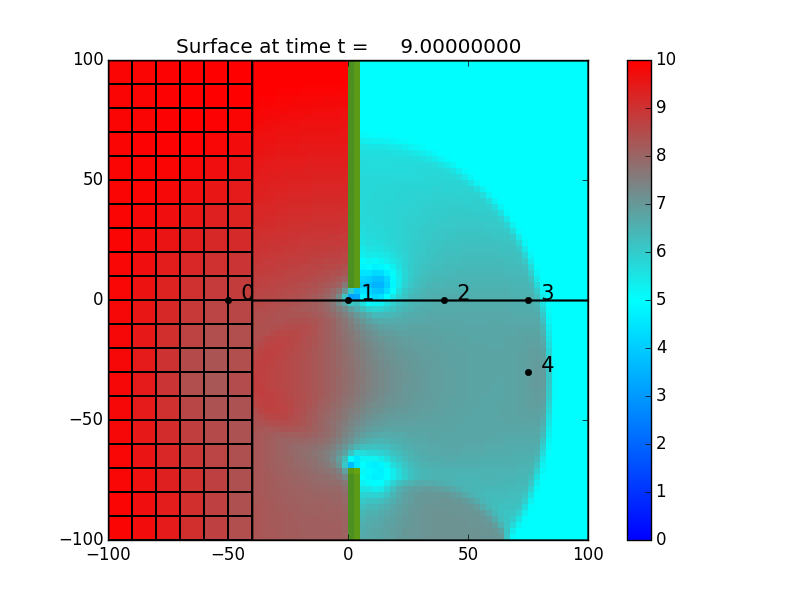

In [15]:
from IPython.display import Image
Image('_plots/frame0009fig0.png',width=400)

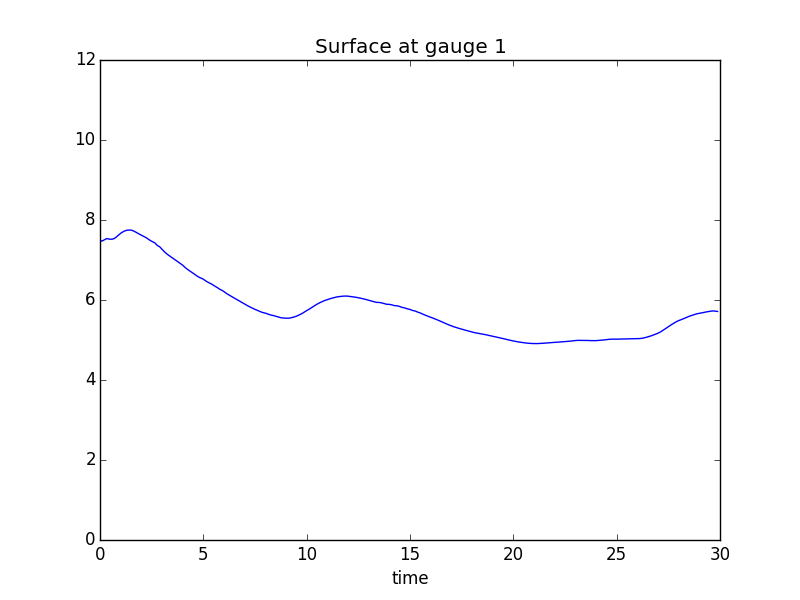

In [16]:
Image('_plots/gauge0001fig200.png',width=400)

## Una pequeña modificación 
Para los resultados puntuales, podemos copiar la sección 
    #-----------------------------------------
    # Figures for gauges
    #-----------------------------------------
en el archivo *setplot.py* y editar la línea 

    plotitem.plot_var = 3
    
y en vez de eso, escribir

    plotitem.plot_var = 1
    
para graficar el caudal unitario $hu$ en vez de la superficie libre.   
La enumeración de las variables es

    0 = h
    1 = hu
    2 = hv
    3 = b + hu
    
donde $h$,$hu$,$hv$ son las variables conservadas  es decir, la altura de la columna de agua (profundidad); el caudal unitario en la dirección $x$, es decir $h\times u$, con $u$ la velocidad;y  el caudal unitario en la dirección $y$; y $b$ es la topografía.

Lo anterior lo pueden ver en la celda a continuación. Comparen la celda con el setplot.py de antes con este!.

    

In [17]:
# %load setplot.py

In [18]:
%%writefile setplot.py
""" 
Set up the plot figures, axes, and items to be done for each frame.

This module is imported by the plotting routines and then the
function setplot is called to set the plot parameters.
    
""" 

#--------------------------
def setplot(plotdata):
#--------------------------
    
    """ 
    Specify what is to be plotted at each frame.
    Input:  plotdata, an instance of pyclaw.plotters.data.ClawPlotData.
    Output: a modified version of plotdata.
    
    """ 


    from clawpack.visclaw import colormaps, geoplot

    plotdata.clearfigures()  # clear any old figures,axes,items data
    
    
    def addgauges(current_data):
        from clawpack.visclaw import gaugetools
        gaugetools.plot_gauge_locations(current_data.plotdata, \
             gaugenos='all', format_string='ko', add_labels=True)
        
    def set_drytol(current_data):
        # The drytol parameter is used in masking land and water and
        # affects what color map is used for cells with small water depth h.
        # The cell will be plotted as dry if h < drytol.
        # The best value to use often depends on the application and can
        # be set here (measured in meters):
        current_data.user["drytol"] = 1.e-3
    

    plotdata.beforeframe = set_drytol

    #-----------------------------------------
    # Figure for pcolor plot
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='pcolor', figno=0)

    # Set up for axes in this figure:F
    plotaxes = plotfigure.new_plotaxes('pcolor')
    plotaxes.title = 'Surface'
    plotaxes.scaled = True

    # Water
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.plot_var = geoplot.surface
    plotitem.pcolor_cmap = geoplot.tsunami_colormap
    plotitem.pcolor_cmin = 0.
    plotitem.pcolor_cmax = 10.
    plotitem.add_colorbar = True
    plotitem.amr_celledges_show = [1,0,0]
    plotitem.patchedges_show = [1,1,1]

    # Land
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.plot_var = geoplot.land
    plotitem.pcolor_cmap = geoplot.land_colors
    plotitem.pcolor_cmin = 0.0
    plotitem.pcolor_cmax = 20.
    plotitem.add_colorbar = False
    plotitem.amr_celledges_show = [1,0,0]
    plotitem.patchedges_show = [1,0,0]
    plotaxes.xlimits = [-100,100]
    plotaxes.ylimits = [-100,100]
    
    plotaxes.afteraxes = addgauges
    
    #-----------------------------------------
    # Figures for gauges
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='Surface at gauges', figno=200, \
                    type='each_gauge')
    plotfigure.clf_each_gauge = True

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.xlimits = 'auto'
    plotaxes.ylimits = [0,12]
    plotaxes.title = 'Surface'

    # Plot surface as blue curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 3
    plotitem.plotstyle = 'b-'

    # Plot topo as green curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.show = False

    def gaugetopo(current_data):
        q = current_data.q
        h = q[0,:]
        eta = q[3,:]
        topo = eta - h
        return topo
        
    plotitem.plot_var = gaugetopo
    plotitem.plotstyle = 'g-'

    #-----------------------------------------
    # Figures for gauges -- COPIA PARA GRAFICAR h*u
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='Caudal unitario en los puntos', figno=300, \
                    type='each_gauge')
    plotfigure.clf_each_gauge = True

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.xlimits = 'auto'
    plotaxes.ylimits = 'auto'
    plotaxes.title = 'Caudal unitario hu'

    # Plot surface as blue curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 1
    plotitem.plotstyle = 'b-'

    # Plot topo as green curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.show = False

    def gaugetopo(current_data):
        q = current_data.q
        h = q[0,:]
        eta = q[3,:]
        topo = eta - h
        return topo
        
    plotitem.plot_var = gaugetopo
    plotitem.plotstyle = 'g-'
    
    #-----------------------------------------
    
    # Parameters used only when creating html and/or latex hardcopy
    # e.g., via pyclaw.plotters.frametools.printframes:

    plotdata.printfigs = True                # print figures
    plotdata.print_format = 'png'            # file format
    plotdata.print_framenos = 'all'          # list of frames to print
    plotdata.print_gaugenos = 'all'            # list of gauges to print
    plotdata.print_fignos = 'all'            # list of figures to print
    plotdata.html = True                     # create html files of plots?
    plotdata.html_homelink = '../README.html'   # pointer for top of index
    plotdata.latex = True                    # create latex file of plots?
    plotdata.latex_figsperline = 2           # layout of plots
    plotdata.latex_framesperline = 1         # layout of plots
    plotdata.latex_makepdf = False           # also run pdflatex?

    return plotdata

    

Overwriting setplot.py


In [19]:
!make plots

makefile:187: warning: overriding commands for target `all'
/home/jgm/Downloads/clawpack-5.3.0/clawutil/src/Makefile.common:259: warning: ignoring old commands for target `all'
rm -f .plots
python /home/jgm/Downloads/clawpack-5.3.0/visclaw/src/python/visclaw/plotclaw.py _output                _plots                setplot.py      
Importing setplot.setplot from /home/jgm/ADH/Taller.
Executed setplot successfully
Will plot 31 frames numbered: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Will make 1 figure(s) for each frame, numbered:  [0]

-----------------------------------


Creating html pages for figures...

Directory '/home/jgm/ADH/Taller/_plots' 
    already exists, files may be overwritten 
Now making png files for all figures...
    Reading  Frame 0 at t = 0  from outdir = /home/jgm/ADH/Taller/_output
Frame 0 at time t = 0.0
    Reading  Frame 1 at t = 1  from outdir = /home/jgm/ADH/Taller/_output
Frame 1 at t

In [20]:
!google-chrome _plots/_PlotIndex.html

[20327:20327:0621/220349:ERROR:browser_main_loop.cc(201)] GTK theme error: Unable to locate theme engine in module_path: "pixmap",
[20327:20327:0621/220349:ERROR:browser_main_loop.cc(201)] GTK theme error: Unable to locate theme engine in module_path: "pixmap",
[20327:20327:0621/220349:ERROR:browser_main_loop.cc(201)] GTK theme error: Unable to locate theme engine in module_path: "pixmap",
[20327:20327:0621/220349:ERROR:browser_main_loop.cc(201)] GTK theme error: Unable to locate theme engine in module_path: "pixmap",
[20327:20327:0621/220349:ERROR:browser_main_loop.cc(201)] GTK theme error: Unable to locate theme engine in module_path: "pixmap",
Gtk-Message: Failed to load module "canberra-gtk-module"
Created new window in existing browser session.


In [21]:
from IPython.display import Image

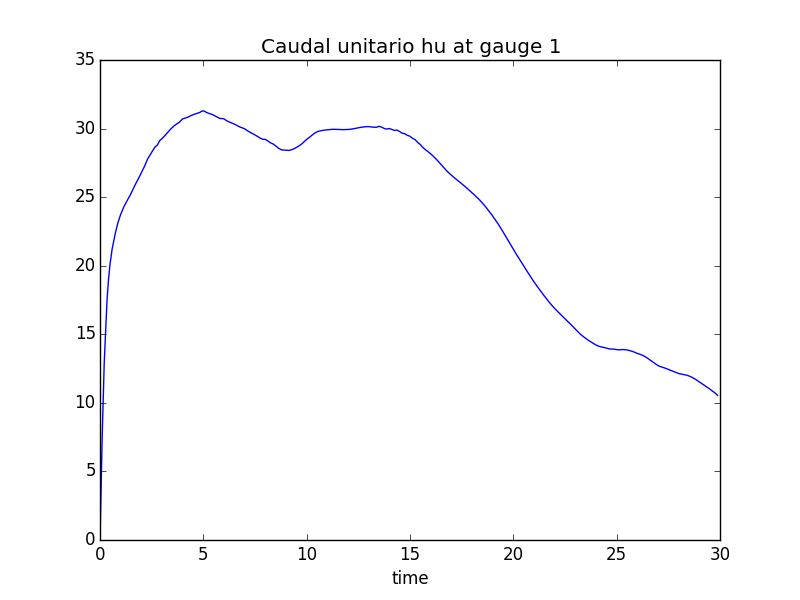

In [22]:
Image('_plots/gauge0001fig300.png',width=400)

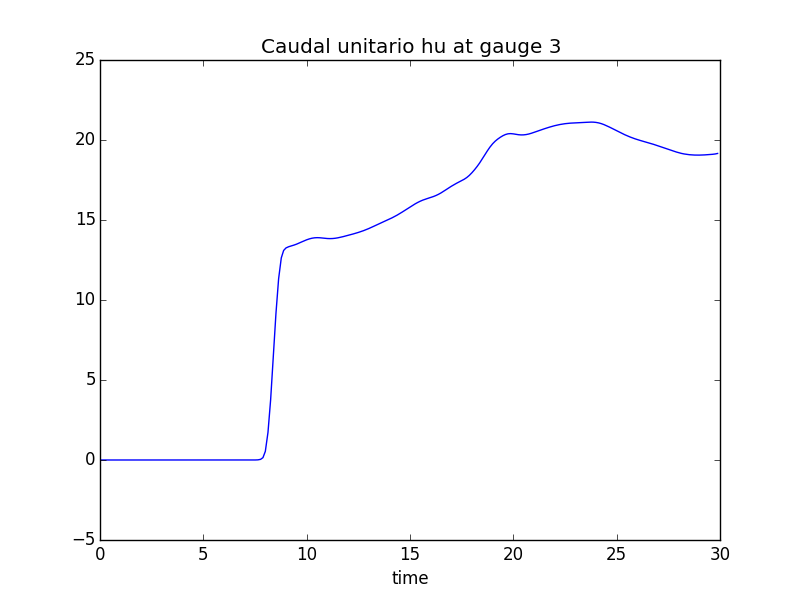

In [23]:
Image('_plots/gauge0003fig300.png',width=400)